## **Chicago 311 - Exploratory Data Analysis**
---


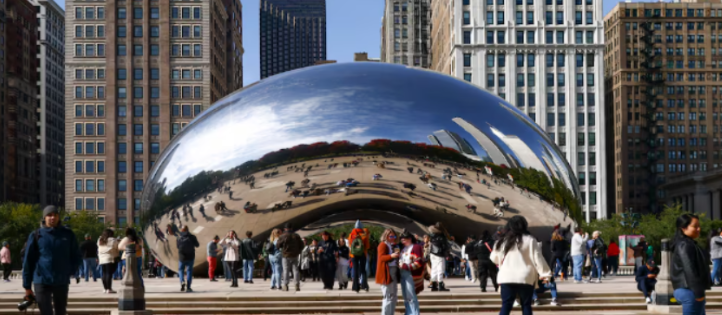

This notebook presents an **Exploratory Data Analysis** of the Chicago 311 [official public data](https://data.cityofchicago.org/Service-Requests/311-Service-Requests/v6vf-nfxy/about_data), with the goals of:
- understanding and describing the dataset's main characteristics and behavioral patterns;
- provide analytical support for downstream modeling [notebooks]()

---


## **Context**


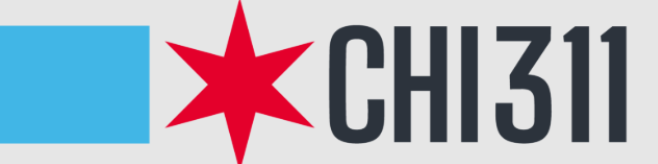

The **[Chicago 311 - Service Requests](https://311.chicago.gov/s/?language=en_US)** is the City of Chicago’s official system for **non-emergency service requests**.

It provides a single access point for residents, businesses, and visitors to *interact with city services*.

**Main purposes**
- Centralize citizen–city communication
- Reduce load on emergency services (911)
- Improve transparency and accountability
- Direct back-up facility for 911

---


### **How it works**
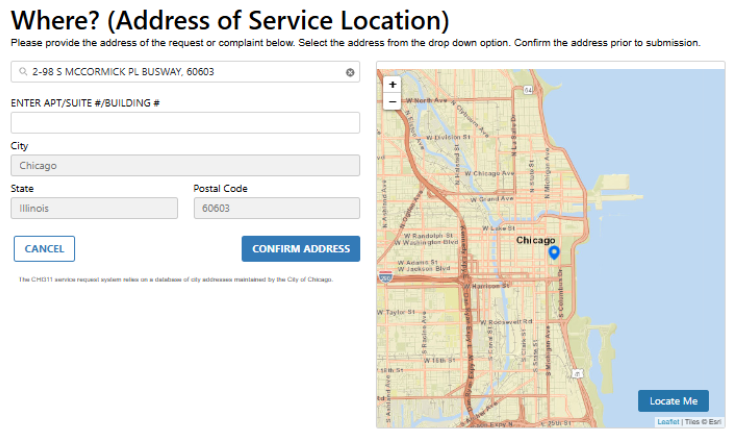
- Service Requests are submitted through different official channels
- Service Requests are routed to the correct city department
- Service Requests status and updates are informed

---


### **Service examples**
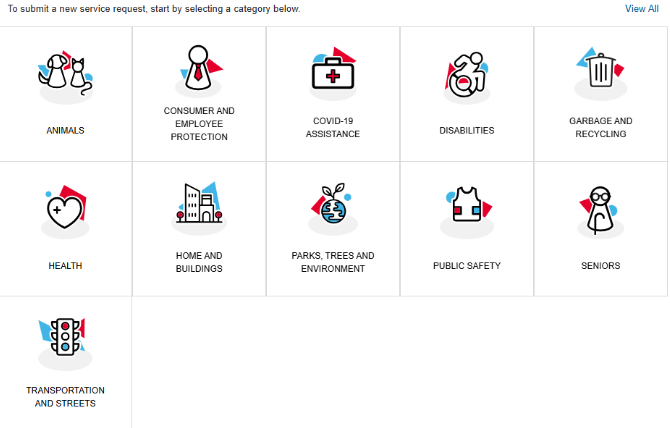

---


### **Data Value**
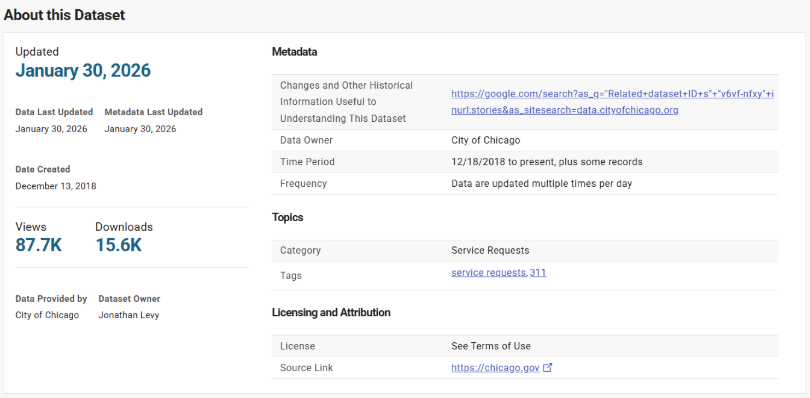
- High-volume, high-quality, spatial and time-stamped records
- Reflects real urban demand
- **[Daily Updated](https://data.cityofchicago.org/Service-Requests/311-Service-Requests/v6vf-nfxy/about_data)** -> will be used in a future **[ML Engineering Project]()**

---


### **Data Context**
---
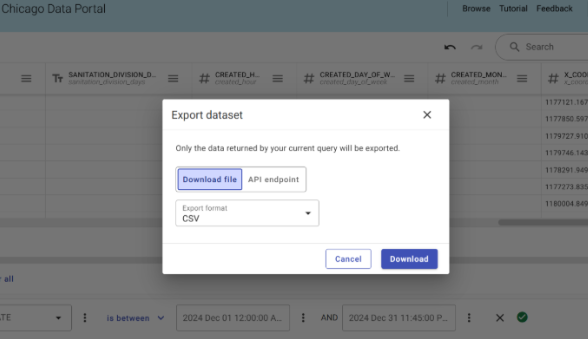
- Data is available via file downloads and an API; **direct CSV downloads** were used for reproducibility.
- **Three years of data** were merged and converted into a **single Parquet file (~7.6M records)**.
- Due to dataset size, **pandas-based EDA can be slow or unstable**.
- **DuckDB with SQL and sampling** is used to enable fast, interactive exploration while preserving representativeness.
- Data ingestion and engineering steps are **out of scope** for this notebook.


## **Preparation**


### **Setting up**


In [1]:
# Importing Python libraries
import numpy as np
from pathlib import Path
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geoviews as gv
import cartopy.crs as ccrs
from holoviews.operation.datashader import datashade
from colorcet import fire

In [2]:
# Initialize DuckDB database
con = duckdb.connect()

### **Loading the Data**


In [3]:
# Preview
# Sample dataset (random seeds)
df_sample = con.execute("""
SELECT *
FROM 'data/processed/data.parquet'
USING SAMPLE .1% -- random sample seeds
""").df()
df_sample
#

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,CITY,CLOSED_DATE,COMMUNITY_AREA,CREATED_DATE,CREATED_DAY_OF_WEEK,CREATED_DEPARTMENT,CREATED_HOUR,CREATED_MONTH,DUPLICATE,ELECTRICAL_DISTRICT,...,STATUS,STREET_ADDRESS,STREET_DIRECTION,STREET_NAME,STREET_NUMBER,STREET_TYPE,WARD,X_COORDINATE,Y_COORDINATE,ZIP_CODE
0,Chicago,2019-07-26 09:18:01,28,2019-07-26 09:18:01,6,311 City Services,9,7,False,None,...,Completed,2111 W Lexington ST,W,Lexington,2111,ST,28,"1162234,142489","1896559,966858",60612
1,Chicago,2019-07-26 09:41:35,28,2019-07-26 09:41:35,6,311 City Services,9,7,False,None,...,Completed,2111 W Lexington ST,W,Lexington,2111,ST,28,"1162234,142489","1896559,966858",60612
2,Chicago,2019-07-26 09:41:41,28,2019-07-26 09:41:41,6,311 City Services,9,7,False,None,...,Completed,2111 W Lexington ST,W,Lexington,2111,ST,28,"1162234,142489","1896559,966858",60612
3,None,2020-09-30 13:18:19,30,2019-07-26 08:39:21,6,311 City Services,8,7,False,None,...,Completed,2814 S KENNETH AVE,S,KENNETH,2814,AVE,22,"1147119,471762","1884818,663112",60623
4,None,2020-11-25 09:45:32,41,2019-07-26 00:40:53,6,311 City Services,0,7,True,None,...,Completed,5720 S ELLIS AVE,S,ELLIS,5720,AVE,5,"1183874,948774","1867424,121031",60637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14331,Chicago,2026-01-12 08:21:52,28,2026-01-12 08:21:52,2,311 City Services,8,1,False,7,...,Completed,2111 W Lexington ST,W,Lexington,2111,ST,28,"1162234,4668753312","1896560,9616219066",60612
14332,Chicago,NaT,9,2026-01-12 08:21:53,2,Alderman,8,1,False,1,...,Open,7351 N OKETO AVE,N,OKETO,7351,AVE,41,"1126147,286562919","1948452,0669922314",60631
14333,Chicago,NaT,11,2026-01-12 08:21:53,2,Alderman,8,1,False,1,...,Open,4855 N MOBILE AVE,N,MOBILE,4855,AVE,45,"1133282,2110206557","1932150,2605715524",60630
14334,Chicago,2026-01-12 10:29:23,28,2026-01-12 08:21:54,2,None,8,1,True,7,...,Completed,640 W WAYMAN ST,W,WAYMAN,640,ST,34,"1171849,940674464","1902341,9444343993",60661


### **Preprocessing**


In [4]:
# Preview (1/4)
df_sample[df_sample.columns[0:10]].info()

#     COLUMN               TYPE                CORRECT TYPE
# 0   CITY                 object              ✅        
# 1   CLOSED_DATE          datetime64[us]      ✅
# 2   COMMUNITY_AREA       Int64               ✅
# 3   CREATED_DATE         datetime64[us]
# 4   CREATED_DAY_OF_WEEK  int64         
# 5   CREATED_DEPARTMENT   object        
# 6   CREATED_HOUR         int64         
# 7   CREATED_MONTH        int64         
# 8   DUPLICATE            bool          
# 9   ELECTRICAL_DISTRICT  object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14336 entries, 0 to 14335
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CITY                 11329 non-null  object        
 1   CLOSED_DATE          13319 non-null  datetime64[us]
 2   COMMUNITY_AREA       14324 non-null  Int64         
 3   CREATED_DATE         14336 non-null  datetime64[us]
 4   CREATED_DAY_OF_WEEK  14336 non-null  int64         
 5   CREATED_DEPARTMENT   8367 non-null   object        
 6   CREATED_HOUR         14336 non-null  int64         
 7   CREATED_MONTH        14336 non-null  int64         
 8   DUPLICATE            14336 non-null  bool          
 9   ELECTRICAL_DISTRICT  1978 non-null   object        
dtypes: Int64(1), bool(1), datetime64[us](2), int64(3), object(3)
memory usage: 1.0+ MB


In [5]:
# Preview (1/4)
df_sample[df_sample.columns[0:10]].head()

#     COLUMN               TYPE                CORRECT TYPE
# 0   CITY                 object              ✅        
# 1   CLOSED_DATE          datetime64[us]      ✅
# 2   COMMUNITY_AREA       Int64               ✅
# 3   CREATED_DATE         datetime64[us]      ✅
# 4   CREATED_DAY_OF_WEEK  int64               ✅
# 5   CREATED_DEPARTMENT   object              ✅
# 6   CREATED_HOUR         int64               ✅
# 7   CREATED_MONTH        int64               ✅
# 8   DUPLICATE            bool                ✅ 
# 9   ELECTRICAL_DISTRICT  object              ✅

,CITY,CLOSED_DATE,COMMUNITY_AREA,CREATED_DATE,CREATED_DAY_OF_WEEK,CREATED_DEPARTMENT,CREATED_HOUR,CREATED_MONTH,DUPLICATE,ELECTRICAL_DISTRICT
0,Chicago,2019-07-26 09:18:01,28,2019-07-26 09:18:01,6,311 City Services,9,7,False,None
1,Chicago,2019-07-26 09:41:35,28,2019-07-26 09:41:35,6,311 City Services,9,7,False,None
2,Chicago,2019-07-26 09:41:41,28,2019-07-26 09:41:41,6,311 City Services,9,7,False,None
3,None,2020-09-30 13:18:19,30,2019-07-26 08:39:21,6,311 City Services,8,7,False,None
4,None,2020-11-25 09:45:32,41,2019-07-26 00:40:53,6,311 City Services,0,7,True,None


In [6]:
# Preview (2/4)
df_sample[df_sample.columns[10:20]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14336 entries, 0 to 14335
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ELECTRICITY_GRID    11477 non-null  object        
 1   LAST_MODIFIED_DATE  14336 non-null  datetime64[us]
 2   LATITUDE            14326 non-null  object        
 3   LEGACY_RECORD       14336 non-null  bool          
 4   LEGACY_SR_NUMBER    0 non-null      object        
 5   LOCATION            14326 non-null  object        
 6   LONGITUDE           14326 non-null  object        
 7   ORIGIN              14336 non-null  object        
 8   OWNER_DEPARTMENT    14336 non-null  object        
 9   PARENT_SR_NUMBER    543 non-null    object        
dtypes: bool(1), datetime64[us](1), object(8)
memory usage: 1022.1+ KB


In [7]:
# Preview (2/4)
df_sample[df_sample.columns[10:20]].head()

#     COLUMN                 TYPE          CORRECT TYPE
# 0   ELECTRICITY_GRID       object        ✅
# 1   LAST_MODIFIED_DATE     datetime64[us]✅
# 2   LATITUDE               object        ❌ -> Int64
# 3   LEGACY_RECORD          bool          ✅
# 4   LEGACY_SR_NUMBER       object        ✅
# 5   LOCATION               object        ✅
# 6   LONGITUDE              object        ❌ -> Int64
# 7   ORIGIN                 object        ✅
# 8   OWNER_DEPARTMENT       object        ✅
# 9   PARENT_SR_NUMBER       object        ✅

,ELECTRICITY_GRID,LAST_MODIFIED_DATE,LATITUDE,LEGACY_RECORD,LEGACY_SR_NUMBER,LOCATION,LONGITUDE,ORIGIN,OWNER_DEPARTMENT,PARENT_SR_NUMBER
0,K024,2019-07-26 09:30:57,"41,87183127799",False,None,"(41.871831277993564, -87.67984621876099)","-87,67984621876",Phone Call,311 City Services,None
1,K024,2019-07-26 10:30:44,"41,87183127799",False,None,"(41.871831277993564, -87.67984621876099)","-87,67984621876",Phone Call,311 City Services,None
2,K024,2019-07-26 10:32:19,"41,87183127799",False,None,"(41.871831277993564, -87.67984621876099)","-87,67984621876",Phone Call,311 City Services,None
3,E028,2020-09-30 13:18:19,"41,83991399223",False,None,"(41.83991399223453, -87.73563881330868)","-87,73563881331",Phone Call,Streets and Sanitation,None
4,S035,2020-11-25 09:45:32,"41,79140104495",False,None,"(41.791401044954, -87.60130649510852)","-87,60130649511",Phone Call,DWM - Department of Water Management,SR19-02036727


In [8]:
# Fixing types (2/4)
con.execute("""
CREATE OR REPLACE VIEW data AS
SELECT * REPLACE(
    REPLACE(LATITUDE,  ',', '.') :: DOUBLE AS LATITUDE,
    REPLACE(LONGITUDE, ',', '.') :: DOUBLE AS LONGITUDE
)
FROM 'data/processed/data.parquet';
""")

# Update preview
df_sample = con.execute("""
SELECT * FROM data USING SAMPLE .1%
""").df()

df_sample[df_sample.columns[10:20]].info()

#     COLUMN                 TYPE          CORRECT TYPE
# 0   ELECTRICITY_GRID       object        ✅
# 1   LAST_MODIFIED_DATE     datetime64[us]✅
# 2   LATITUDE               object        ❌ -> Int64 ✅
# 3   LEGACY_RECORD          bool          ✅
# 4   LEGACY_SR_NUMBER       object        ✅
# 5   LOCATION               object        ✅
# 6   LONGITUDE              object        ❌ -> Int64 ✅
# 7   ORIGIN                 object        ✅
# 8   OWNER_DEPARTMENT       object        ✅
# 9   PARENT_SR_NUMBER       object        ✅

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28672 entries, 0 to 28671
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ELECTRICITY_GRID    22878 non-null  object        
 1   LAST_MODIFIED_DATE  28672 non-null  datetime64[us]
 2   LATITUDE            28641 non-null  float64       
 3   LEGACY_RECORD       28672 non-null  bool          
 4   LEGACY_SR_NUMBER    0 non-null      object        
 5   LOCATION            28641 non-null  object        
 6   LONGITUDE           28641 non-null  float64       
 7   ORIGIN              28672 non-null  object        
 8   OWNER_DEPARTMENT    28672 non-null  object        
 9   PARENT_SR_NUMBER    1488 non-null   object        
dtypes: bool(1), datetime64[us](1), float64(2), object(6)
memory usage: 2.0+ MB


In [9]:
# Preview (3/4)
df_sample[df_sample.columns[20:30]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28672 entries, 0 to 28671
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   POLICE_BEAT               28628 non-null  object
 1   POLICE_DISTRICT           28628 non-null  object
 2   POLICE_SECTOR             28628 non-null  Int64 
 3   PRECINCT                  28624 non-null  Int64 
 4   SANITATION_DIVISION_DAYS  0 non-null      object
 5   SR_NUMBER                 28672 non-null  object
 6   SR_SHORT_CODE             28672 non-null  object
 7   SR_TYPE                   28672 non-null  object
 8   STATE                     20438 non-null  object
 9   STATUS                    28672 non-null  object
dtypes: Int64(2), object(8)
memory usage: 2.2+ MB


In [10]:
# Preview (3/4)
df_sample[df_sample.columns[20:30]].head()

#     Column                        Dtype  CORRECT TYPE
# 0   POLICE_BEAT                    object✅
# 1   POLICE_DISTRICT                object✅
# 2   POLICE_SECTOR                  Int64 ✅
# 3   PRECINCT                       Int64 ✅
# 4   SANITATION_DIVISION_DAYS       object✅
# 5   SR_NUMBER                      object✅
# 6   SR_SHORT_CODE                  object✅
# 7   SR_TYPE                        object✅
# 8   STATE                          object✅
# 9   STATUS                         object✅

,POLICE_BEAT,POLICE_DISTRICT,POLICE_SECTOR,PRECINCT,SANITATION_DIVISION_DAYS,SR_NUMBER,SR_SHORT_CODE,SR_TYPE,STATE,STATUS
0,1724,17,2,20,None,SR19-01935982,PHF,Pothole in Street Complaint,None,Completed
1,1724,17,2,20,None,SR19-01935983,PCE,Sign Repair Request - All Other Signs,None,Completed
2,1633,16,3,21,None,SR19-01935984,PBD,Inspect Public Way Request,None,Completed
3,1225,12,2,46,None,SR19-01935985,311IOC,311 INFORMATION ONLY CALL,Illinois,Completed
4,1724,17,2,8,None,SR19-01935986,PHF,Pothole in Street Complaint,None,Completed


In [11]:
# Preview (4/4)
df_sample[df_sample.columns[30:40]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28672 entries, 0 to 28671
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   STREET_ADDRESS    28642 non-null  object
 1   STREET_DIRECTION  28625 non-null  object
 2   STREET_NAME       28642 non-null  object
 3   STREET_NUMBER     28625 non-null  object
 4   STREET_TYPE       28411 non-null  object
 5   WARD              28631 non-null  Int64 
 6   X_COORDINATE      28642 non-null  object
 7   Y_COORDINATE      28642 non-null  object
 8   ZIP_CODE          27258 non-null  object
dtypes: Int64(1), object(8)
memory usage: 2.0+ MB


In [12]:
# Preview (4/4)
df_sample[df_sample.columns[30:40]]

# 0   STREET_ADDRESS       object✅
# 1   STREET_DIRECTION     object✅
# 2   STREET_NAME          object✅
# 3   STREET_NUMBER        object✅
# 4   STREET_TYPE          object✅
# 5   WARD                 Int64 ✅
# 6   X_COORDINATE         object❌ -> Int64 ✅
# 7   Y_COORDINATE         object❌ -> Int64 ✅
# 8   ZIP_CODE             object✅

,STREET_ADDRESS,STREET_DIRECTION,STREET_NAME,STREET_NUMBER,STREET_TYPE,WARD,X_COORDINATE,Y_COORDINATE,ZIP_CODE
0,3056 W SUNNYSIDE AVE,W,SUNNYSIDE,3056,AVE,33,"1154904,660926","1929743,096344",60625
1,3110 W MONTROSE AVE,W,MONTROSE,3110,AVE,33,"1154790,842501","1929192,376525",60618
2,6143 W IRVING PARK RD,W,IRVING PARK,6143,RD,38,"1134508,043411","1925787,800732",60634
3,2111 W Lexington ST,W,Lexington,2111,ST,28,"1162234,142489","1896559,966858",60612
4,4458 N WHIPPLE ST,N,WHIPPLE,4458,ST,33,"1155237,299396","1929748,195168",60625
...,...,...,...,...,...,...,...,...,...
28667,2111 W Lexington ST,W,Lexington,2111,ST,28,"1162234,4668753312","1896560,9616219066",60612
28668,10510 W ZEMKE RD,W,ZEMKE,10510,RD,41,"1105376,7673561182","1941043,7883293368",60666
28669,10510 W ZEMKE RD,W,ZEMKE,10510,RD,41,"1105376,7673561182","1941043,7883293368",60666
28670,2111 W Lexington ST,W,Lexington,2111,ST,28,"1162234,4668753312","1896560,9616219066",60612


In [ ]:
# Fixing types (4/4)
# Cast new types
con.execute("""
CREATE OR REPLACE VIEW data_2 AS
SELECT * REPLACE(
    regexp_replace(X_COORDINATE, ',', '.', 'g')::DOUBLE AS X_COORDINATE,
    regexp_replace(Y_COORDINATE, ',', '.', 'g')::DOUBLE AS Y_COORDINATE,
)
FROM data;
""")
# Update preview
df_sample = con.execute("""
SELECT * FROM data_2 USING SAMPLE .1%
""").df()
# Pandas preview
df_sample[df_sample.columns[30:40]].info()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20480 entries, 0 to 20479
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   STREET_ADDRESS    20462 non-null  object 
 1   STREET_DIRECTION  20461 non-null  object 
 2   STREET_NAME       20462 non-null  object 
 3   STREET_NUMBER     20462 non-null  object 
 4   STREET_TYPE       20204 non-null  object 
 5   WARD              20450 non-null  Int64  
 6   X_COORDINATE      20461 non-null  float64
 7   Y_COORDINATE      20461 non-null  float64
 8   ZIP_CODE          19316 non-null  object 
dtypes: Int64(1), float64(2), object(6)
memory usage: 1.4+ MB


In [15]:
con.execute("""
CREATE OR REPLACE VIEW data_3 AS
SELECT DISTINCT *
FROM data_2;
""")

# Update preview
df_sample = con.execute("""
SELECT * FROM data_3 USING SAMPLE .1%
""").df()

df_sample

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,CITY,CLOSED_DATE,COMMUNITY_AREA,CREATED_DATE,CREATED_DAY_OF_WEEK,CREATED_DEPARTMENT,CREATED_HOUR,CREATED_MONTH,DUPLICATE,ELECTRICAL_DISTRICT,...,STATUS,STREET_ADDRESS,STREET_DIRECTION,STREET_NAME,STREET_NUMBER,STREET_TYPE,WARD,X_COORDINATE,Y_COORDINATE,ZIP_CODE
0,Chicago,2020-10-08 08:59:10,28,2020-10-08 08:59:09,5,311 City Services,8,10,False,None,...,Completed,2111 W Lexington ST,W,Lexington,2111,ST,27,1.162393e+06,1.899541e+06,60612
1,None,2021-03-23 11:45:31,72,2020-10-07 19:28:23,4,None,19,10,False,None,...,Completed,10409 S PROSPECT AVE,S,PROSPECT,10409,AVE,19,1.167665e+06,1.835630e+06,60643
2,Chicago,2020-10-07 19:31:48,76,2020-10-07 19:31:47,4,None,19,10,False,None,...,Completed,10510 W ZEMKE RD,W,ZEMKE,10510,RD,41,1.105376e+06,1.941043e+06,60666
3,None,2020-10-07 20:05:02,12,2020-10-07 19:39:52,4,None,19,10,False,None,...,Canceled,7076 N MASON AVE,N,MASON,7076,AVE,41,1.136130e+06,1.946709e+06,60646
4,None,2020-10-23 13:33:50,56,2020-10-07 19:50:22,4,None,19,10,False,None,...,Completed,5806 S MEADE AVE,S,MEADE,5806,AVE,13,1.136641e+06,1.865358e+06,60638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6896,None,2026-02-02 12:39:16,76,2026-02-02 12:13:37,2,None,12,2,False,1,...,Completed,5033 N CHESTER AVE,N,CHESTER,5033,AVE,41,1.118912e+06,1.932417e+06,None
6897,Chicago,2026-02-02 12:51:30,28,2026-02-02 12:51:30,2,311 City Services,12,2,False,7,...,Completed,2111 W Lexington ST,W,Lexington,2111,ST,28,1.162234e+06,1.896561e+06,60612
6898,Chicago,NaT,67,2026-02-02 12:56:51,2,311 City Services,12,2,False,11,...,Open,6451 S WINCHESTER AVE,S,WINCHESTER,6451,AVE,16,1.164539e+06,1.861682e+06,60636
6899,Chicago,2026-02-02 13:42:58,64,2026-02-02 13:42:53,2,None,13,2,False,10,...,Completed,6237 W 63RD ST,W,63RD,6237,ST,13,1.135758e+06,1.862016e+06,60638


## **Exploratory Data Analysis**


#### **Structure Overview**


In [16]:
# Shape
con.execute("""SELECT * FROM data_2""").df().shape
# read and discard the object
# 13301203 rows x 39 columns

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(13301203, 39)

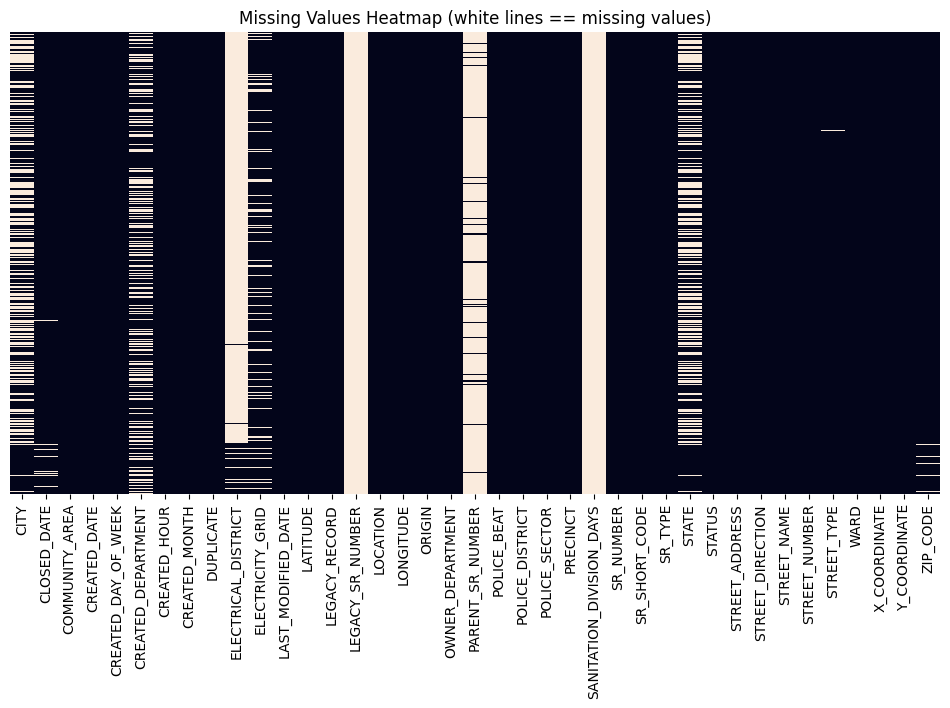

In [17]:
# Vizualizing missing data with sampling
df_sample = df_sample.sort_values("CREATED_DATE")
plt.figure(figsize=(12, 6))
sns.heatmap(df_sample.isna(), cbar=False, yticklabels=False)
plt.title('Missing Values Heatmap (white lines == missing values)')
plt.show()
# white lines -> missing values

In [18]:
# High missingess %
(df_sample.isna().mean().sort_values(ascending=False).head(25) * 100).round(decimals=2)
# High missingess columns:
# Unusable! (>60%)
# ==================
# LEGACY_SR_NUMBER
# PARENT_SR_NUMBER
# ELECTRICAL_DISTRICT
# "Repairable" if necessary
# ==================
# CREATED_DEPARTMENT
# STATE
# CITY
# ELETRICITY_GRID
# ZIP_CODE
#

LEGACY_SR_NUMBER            100.00
SANITATION_DIVISION_DAYS    100.00
PARENT_SR_NUMBER             94.55
ELECTRICAL_DISTRICT          91.06
CITY                         41.46
STATE                        41.46
CREATED_DEPARTMENT           34.66
ELECTRICITY_GRID             13.61
ZIP_CODE                      1.38
CLOSED_DATE                   1.35
STREET_TYPE                   0.68
PRECINCT                      0.14
POLICE_DISTRICT               0.09
WARD                          0.09
COMMUNITY_AREA                0.09
POLICE_SECTOR                 0.09
POLICE_BEAT                   0.09
X_COORDINATE                  0.06
STREET_NAME                   0.06
STREET_NUMBER                 0.06
LOCATION                      0.06
LONGITUDE                     0.06
LATITUDE                      0.06
STREET_DIRECTION              0.06
STREET_ADDRESS                0.06
dtype: float64

In [19]:
# Excluding columnS
con.execute("""
CREATE OR REPLACE VIEW data_6 AS
SELECT * EXCLUDE(
         LEGACY_SR_NUMBER,
         SANITATION_DIVISION_DAYS, 
         PARENT_SR_NUMBER, 
         ELECTRICAL_DISTRICT)
FROM data_2;
""")
df_sample = con.execute("""
SELECT * FROM data_6 USING SAMPLE .1%
""").df()
(df_sample.isna().mean().sort_values(ascending=False).head(25) * 100).round(decimals=2)
#

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CREATED_DEPARTMENT    32.91
STATE                 31.58
CITY                  31.58
ELECTRICITY_GRID      13.87
ZIP_CODE               4.20
CLOSED_DATE            1.24
STREET_TYPE            1.06
PRECINCT               0.11
POLICE_SECTOR          0.11
POLICE_DISTRICT        0.11
POLICE_BEAT            0.11
COMMUNITY_AREA         0.10
WARD                   0.10
LOCATION               0.07
LATITUDE               0.07
LONGITUDE              0.07
STREET_DIRECTION       0.05
STREET_ADDRESS         0.05
STREET_NUMBER          0.05
X_COORDINATE           0.05
STREET_NAME            0.05
Y_COORDINATE           0.05
ORIGIN                 0.00
CREATED_HOUR           0.00
CREATED_MONTH          0.00
dtype: float64

#### **Categorical Columns Analysis**


In [20]:
con.execute("""
SELECT column_name, data_type
FROM information_schema.columns
WHERE table_name = 'data_6' AND data_type = 'VARCHAR'
""").df()
# Our Focus:
# SR_TYPE
# CREATED_DEPARTMENT
# OWNER_DEPARTMENT
# STATUS
# ORIGIN
# CITY
# STATE

,column_name,data_type
0,CITY,VARCHAR
1,CREATED_DEPARTMENT,VARCHAR
2,ELECTRICITY_GRID,VARCHAR
3,LOCATION,VARCHAR
4,ORIGIN,VARCHAR
5,OWNER_DEPARTMENT,VARCHAR
6,POLICE_BEAT,VARCHAR
7,POLICE_DISTRICT,VARCHAR
8,SR_NUMBER,VARCHAR
9,SR_SHORT_CODE,VARCHAR


##### **SR_TYPE**


In [21]:
# SR_TYPE top 20
(df_sample['SR_TYPE']
 .value_counts(normalize=True)
 .sort_values(ascending=False) * 100
).round(decimals=2).head(20)
# Information only + Aircraft noise - dominate the distribution

SR_TYPE
311 INFORMATION ONLY CALL                       39.11
Aircraft Noise Complaint                        13.74
Graffiti Removal Request                         3.97
Garbage Cart Maintenance                         3.79
Tree Debris Clean-Up Request                     2.85
Rodent Baiting/Rat Complaint                     2.77
Street Light Out Complaint                       2.41
Abandoned Vehicle Complaint                      2.10
Pothole in Street Complaint                      2.00
Tree Emergency                                   1.74
Weed Removal Request                             1.73
Traffic Signal Out Complaint                     1.48
Blue Recycling Cart                              1.37
Building Violation                               1.17
Sanitation Code Violation                        1.07
Tree Trim Request (NO LONGER BEING ACCEPTED)     1.04
Sign Repair Request - All Other Signs            1.04
Open Fire Hydrant Complaint                      1.01
Tree Removal Inspect

In [22]:
# Possible rare yet high SLA impact event examples
long_tail = con.execute("""
SELECT
    SR_TYPE,
    ROUND(AVG(DATE_DIFF('day', CREATED_DATE, CLOSED_DATE)), 2) AS avg_days_open,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) AS pct
FROM data_6
WHERE CREATED_DATE IS NOT NULL
  AND CLOSED_DATE IS NOT NULL
  AND SR_TYPE NOT ILIKE '%tree%'
GROUP BY SR_TYPE
ORDER BY avg_days_open DESC, pct DESC
LIMIT 20;
""").df()
long_tail
# Tree-related requests dominate counts due to semantic grouping,
# so they are excluded to highlight other high-SLA-impact categories.

,SR_TYPE,avg_days_open,pct
0,Sidewalk Inspection Request,702.01,0.38
1,Shared Cost Sidewalk Program Request,470.58,0.08
2,Commercial Fire Safety Inspection Request,442.29,0.02
3,Bicycle Request/Complaint,317.90,0.04
4,Protected Bike Lane - Debris Removal,308.23,0.01
5,Licensed Pharmaceutical Representative Complaint,286.12,0.00
6,Water Lead Test Visit Request,218.75,0.12
7,Water Lead Test Kit Request,205.30,0.37
8,Paid Sick Leave Violation,204.29,0.01
9,Viaduct Light Out Complaint,175.82,0.03


##### **CREATED_DEPARTMENT**


In [23]:
# CREATED_DEPARTMENT top 20
(df_sample['CREATED_DEPARTMENT']
 .value_counts(normalize=True)
 .sort_values(ascending=False) * 100
).round(decimals=2).head(20)
# 311 City Services dominates the distribution

CREATED_DEPARTMENT
311 City Services                                  85.74
Alderman                                            7.74
Streets and Sanitation                              3.20
CDOT - Department of Transportation                 2.96
Animal Care and Control                             0.17
DWM - Department of Water Management                0.15
Police                                              0.02
BACP - Business Affairs and Consumer Protection     0.02
Name: proportion, dtype: float64

##### **OWNER_DEPARTMENT**


In [24]:
# OWNER_DEPARTMENT top 20
(df_sample['OWNER_DEPARTMENT']
 .value_counts(normalize=True)
 .sort_values(ascending=False) * 100
).round(decimals=2).head(20)
# 311 City Services + Aviation - Still dominant
# Streets and Sanitation + CDOT - Appears with high frequency now (possibly after misplacement fix?)

OWNER_DEPARTMENT
311 City Services                                  39.11
Streets and Sanitation                             27.59
Aviation                                           13.74
CDOT - Department of Transportation                 9.77
DWM - Department of Water Management                3.61
Animal Care and Control                             2.13
DOB - Buildings                                     1.99
BACP - Business Affairs and Consumer Protection     0.81
Finance                                             0.65
Health                                              0.21
Outside Agencies                                    0.21
Department of Housing                               0.08
City Clerk's Office                                 0.07
Fire                                                0.03
Name: proportion, dtype: float64

##### **STATUS**


In [25]:
# STATUS top 20
(df_sample['STATUS']
 .value_counts(normalize=True)
 .sort_values(ascending=False) * 100
).round(decimals=2).head(20)
# >90% of requests are marked as "Completed".
# closure may be driven by automatic rules or operational workflows,
# which could bias SLA/time-to-close modeling and class imbalance.

STATUS
Completed    97.23
Canceled      1.53
Open          1.24
Name: proportion, dtype: float64

In [26]:
# Top Not completed
not_completed = con.execute("""
SELECT
    SR_TYPE,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) AS pct,
    ROUND(AVG(DATE_DIFF('day', CREATED_DATE, CLOSED_DATE)), 2) AS avg_days_open
FROM data_6
WHERE CREATED_DATE IS NOT NULL
  AND CLOSED_DATE IS NOT NULL
  AND STATUS != 'Completed'
GROUP BY SR_TYPE
ORDER BY pct DESC, avg_days_open DESC
LIMIT 20;
""").df()
not_completed
# Stray Animal: unresolved/unsuccessful capture ?
# Water and Tree related categories dominate operational workload even outside "Completed".

,SR_TYPE,pct,avg_days_open
0,Stray Animal Complaint,15.43,9.45
1,Street Light Out Complaint,6.99,21.96
2,Tree Debris Clean-Up Request,6.15,4.24
3,Check for Leak,5.30,0.82
4,Tree Removal Inspection,5.28,87.34
5,No Water Complaint,4.45,0.13
6,Water Lead Test Kit Request,4.03,88.59
7,Sewer Cleaning Inspection Request,3.97,69.94
8,Open Fire Hydrant Complaint,3.50,0.29
9,Water On Street Complaint,3.09,1.32


##### **ORIGIN**


In [27]:
# ORIGIN top 20
(df_sample['ORIGIN']
 .value_counts(normalize=True)
 .sort_values(ascending=False) * 100
).round(decimals=2).head(20)

ORIGIN
Phone Call                    61.56
Internet                      22.97
Mobile Device                  6.95
Alderman's Office              5.55
Mass Entry                     1.92
Salesforce Mobile App          0.55
City Department                0.15
spot-open311-Chicago+Works     0.10
spot-open311-SeeClickFix       0.08
DWM                            0.07
Generated In House             0.05
SPOTCSR                        0.03
Social Media                   0.02
spot-open311-CHITEXT           0.02
Name: proportion, dtype: float64

In [28]:
# Rare yet High impact events (long tail)
long_tail = con.execute("""
SELECT
    ORIGIN,
    ROUND(AVG(DATE_DIFF('day', CREATED_DATE, CLOSED_DATE)), 2) AS avg_days_open,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) AS pct
FROM data_6
WHERE CREATED_DATE IS NOT NULL
  AND CLOSED_DATE IS NOT NULL
GROUP BY ORIGIN
ORDER BY avg_days_open DESC, pct DESC;
""").df()
long_tail
# Legacy methods are very slow yet very rare
# E-mail, though modern, is slow and rare as mail
# Walking-in beats a State Representative by almost a week!
# A phone call is probably the most reliable way to register a complain!

,ORIGIN,avg_days_open,pct
0,Correspondence Tracking,532.00,0.00
1,spot-open311-Zencity,438.50,0.00
2,Spot311 Interface,386.03,0.01
3,SPOT311,282.33,0.00
4,Open311 Interface,221.15,0.00
5,Web,135.45,0.00
6,spot-open311-Fix+311,127.77,0.00
7,RMS,98.51,0.00
8,spot-open311-SeeClickFix,82.09,0.08
9,Fax,79.63,0.00


#### **Time/Date Columns Analysis**


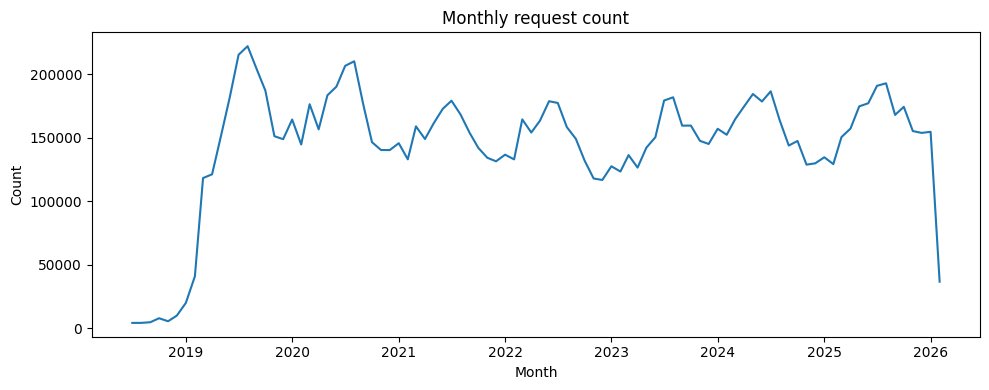

In [30]:
df_month = con.execute("""
SELECT
    DATE_TRUNC('month', CREATED_DATE) AS month,
    COUNT(*) AS n
FROM data_6
GROUP BY 1
ORDER BY 1
""").df()

plt.figure(figsize=(10, 4))
plt.plot(df_month["month"], df_month["n"])
plt.title("Monthly request count")
plt.xlabel("Month")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Series shows higher counts in the middle of the year
# Lower counts at the start/end of the year
# Might indicates sazonality
# Annual maximum and minimum counts have been increasing since 2022

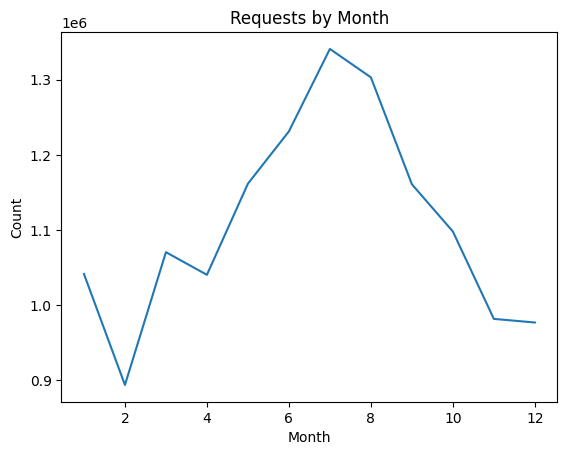

In [32]:
# Requests by month
df_month = con.execute("""
SELECT CREATED_MONTH, COUNT(*) AS n
FROM data_6
GROUP BY CREATED_MONTH
ORDER BY CREATED_MONTH
""").df()

df_month.plot(x="CREATED_MONTH", y="n", legend=False)
plt.title("Requests by Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()

# November to February -> lowest requests counts
# May to August -> highest requests counts

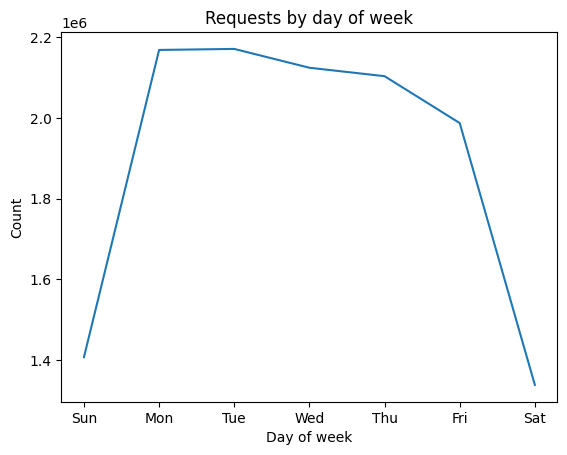

In [33]:
# Requests by day of week (1=Sunday ... 7=Saturday)
df_dow = con.execute("""
SELECT CREATED_DAY_OF_WEEK, COUNT(*) AS n
FROM data_6
GROUP BY 1
ORDER BY 1
""").df()

ax = df_dow.plot(x="CREATED_DAY_OF_WEEK", y="n", legend=False)
ax.set_xticks([1, 2, 3, 4, 5, 6, 7])
ax.set_xticklabels(["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
ax.set_title("Requests by day of week")
ax.set_xlabel("Day of week")
ax.set_ylabel("Count")
plt.show()
# Most of request volumes in work days

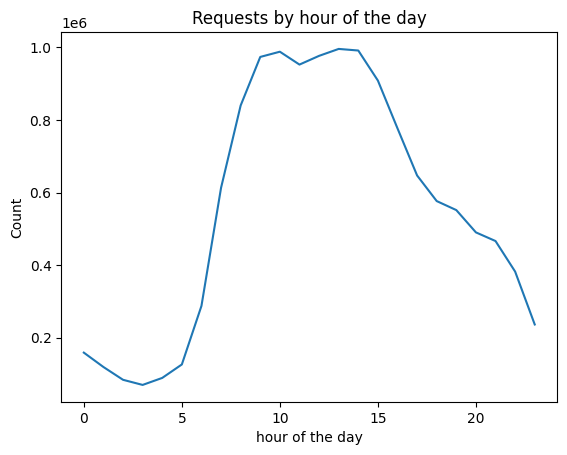

In [34]:
# Requests by hour of the day
df_hour = con.execute("""
SELECT CREATED_HOUR, COUNT(*) AS n
FROM data_6
GROUP BY CREATED_HOUR
ORDER BY CREATED_HOUR
""").df()

df_hour.plot(x="CREATED_HOUR", y="n", legend=False)
plt.title("Requests by hour of the day")
plt.xlabel("hour of the day")
plt.ylabel("Count")
plt.show()
# Most of requests in work hours

#### **Spatial Columns Analysis**


In [35]:
# % valid coordinates
stats = con.execute("""
SELECT
    COUNT(*) AS n_total,
    COUNT(*) FILTER (
        WHERE latitude BETWEEN -90 AND 90
          AND longitude BETWEEN -180 AND 180
    ) AS n_valid
FROM data_6
""").df()
stats["pct_valid"] = stats["n_valid"] / stats["n_total"]
stats["pct_valid"]
# almost 100%

0    0.998965
Name: pct_valid, dtype: float64

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
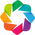

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

BokehModel(combine_events=True, render_bundle={'docs_json': {'972e9197-24dd-4545-8f6a-e2e8b945fd3f': {'version…

In [36]:
gv.extension("bokeh")
df = con.execute("""
SELECT latitude AS lat, longitude AS lon
FROM data_6
WHERE latitude IS NOT NULL AND longitude IS NOT NULL
""").df()

(
    gv.tile_sources.CartoDark()
    * datashade(
        gv.Points(df, ["lon", "lat"]),
        cmap="fire",
        width=600,
        height=600,
        expand=False
    )
).opts(width=400, height=400)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
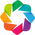

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

BokehModel(combine_events=True, render_bundle={'docs_json': {'c55a0d33-b824-4164-8d22-4e52d9d61b68': {'version…

In [37]:
# Service Requests Density
gv.extension("bokeh")
df = con.execute("""
SELECT latitude AS lat, longitude AS lon
FROM data_6
WHERE latitude IS NOT NULL AND longitude IS NOT NULL
""").df()

points = gv.Points(df, ["lon", "lat"])
shaded = datashade(points, width=1200, height=1200, cmap=fire, cnorm='eq_hist')
(gv.tile_sources.CartoDark * shaded).opts(width=400, height=400)

# Service requests are denser in the north, particularly along the central–northeast lakefront,
# with a clear decline toward the south and higher activity along major arterial roads.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
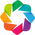

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

BokehModel(combine_events=True, render_bundle={'docs_json': {'0853e77f-d574-4652-a657-f0bb9b3a886a': {'version…

In [38]:
gv.extension("bokeh")
df = con.execute("""
SELECT
    longitude AS lon,
    latitude AS lat,
    EXTRACT(EPOCH FROM (COALESCE(closed_date, now()) - created_date)) / 86400 AS open_days
FROM data_6
WHERE latitude IS NOT NULL AND longitude IS NOT NULL
""").df()

# Non linearity
df["open_days"] = np.log1p(df["open_days"])

points = gv.Points(df, kdims=["lon", "lat"], vdims=["open_days"])
shaded = datashade(
    points,
    aggregator="mean",
    width=1200,
    height=1200,
    cmap=fire,
    cnorm="eq_hist",
    expand=False
)
(gv.tile_sources.CartoDark * shaded).opts(width=400, height=400)

# Service Request times are higher in the periphery—especially the south
# Northwest—while the center is handled faster.
#

#### **Column relationship analysis**


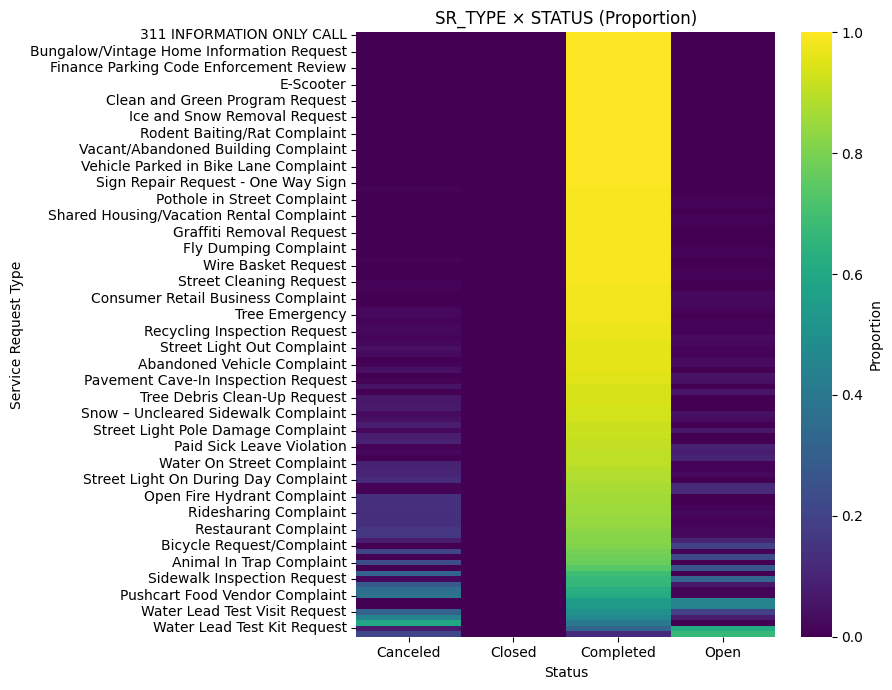

In [39]:
# SR_TYPE × STATUS — heatmap
df_SR_status = con.execute("""
SELECT
    SR_TYPE,
    STATUS,
    COUNT(*) AS n,
    COUNT(*) * 1.0 / SUM(COUNT(*)) OVER (PARTITION BY SR_TYPE) AS pct
FROM data_6
GROUP BY SR_TYPE, STATUS
ORDER BY SR_TYPE, pct DESC
""").df()

df_SR_status["pct"] = df_SR_status["pct"].round(2)

# order by % Completed (ascending)
order = (
    df_SR_status[df_SR_status["STATUS"] == "Completed"]
    .sort_values("pct", ascending=False)["SR_TYPE"]
)

piv = (
    df_SR_status
    .pivot(index="SR_TYPE", columns="STATUS", values="pct")
    .loc[order]
    .fillna(0)
)

plt.figure(figsize=(9, 7))
sns.heatmap(piv, cmap="viridis", annot=False, fmt=".2f", cbar_kws={"label": "Proportion"})
plt.xlabel("Status")
plt.ylabel("Service Request Type")
plt.title("SR_TYPE × STATUS (Proportion)")
plt.tight_layout()
plt.show()

# many SR_TYPES are near-deterministic in outcome ('Completed')
# this high predictability implies limited opportunities for modeling SR_STATUS.
#

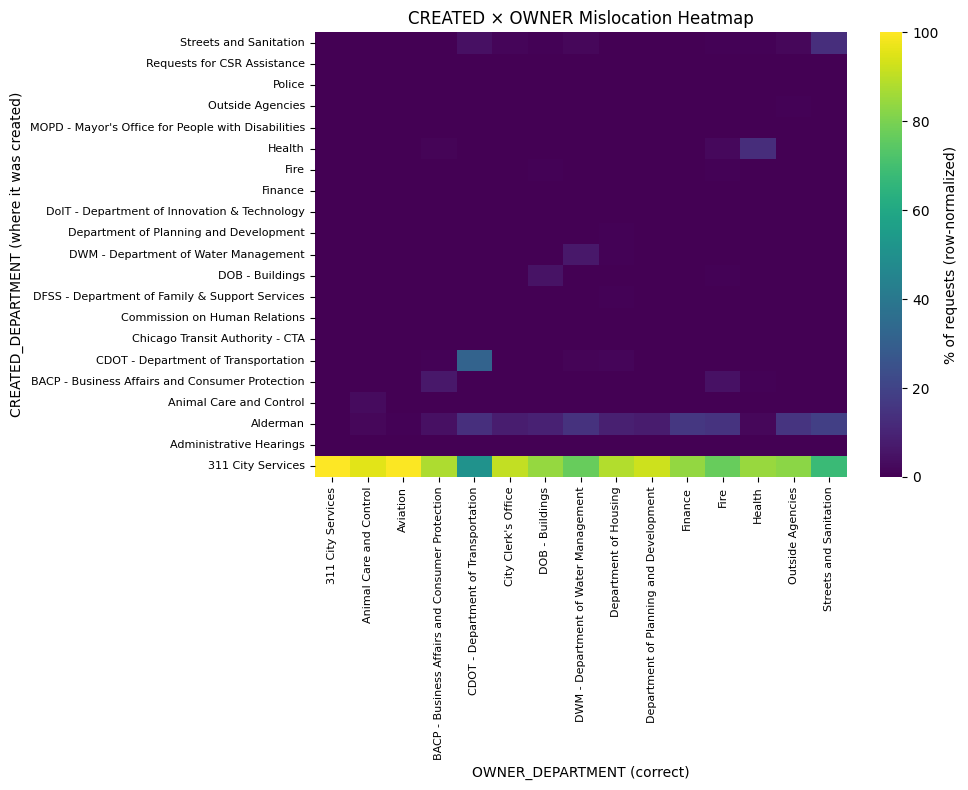

In [40]:
# CREATED × OWNER mislocation heatmap
df_hm = con.execute("""
WITH agg AS (
    SELECT
        OWNER_DEPARTMENT,
        CREATED_DEPARTMENT,
        COUNT(*) AS n
    FROM data_6
    WHERE OWNER_DEPARTMENT IS NOT NULL AND CREATED_DEPARTMENT IS NOT NULL
    GROUP BY 1, 2
),
tot AS (
    SELECT OWNER_DEPARTMENT, SUM(n) AS total_n
    FROM agg
    GROUP BY 1
),
mis AS (
    SELECT
        a.OWNER_DEPARTMENT,
        a.CREATED_DEPARTMENT,
        (a.n * 100.0) / t.total_n AS pct
    FROM agg a
    JOIN tot t
      ON a.OWNER_DEPARTMENT = t.OWNER_DEPARTMENT
),
mis_rate AS (
    SELECT
        OWNER_DEPARTMENT,
        SUM(CASE WHEN CREATED_DEPARTMENT <> OWNER_DEPARTMENT THEN pct ELSE 0 END) AS mis_pct
    FROM mis
    GROUP BY 1
)
SELECT
    m.OWNER_DEPARTMENT,
    m.CREATED_DEPARTMENT,
    m.pct
FROM mis m
JOIN mis_rate r
  ON m.OWNER_DEPARTMENT = r.OWNER_DEPARTMENT
ORDER BY r.mis_pct DESC
""").df()

piv = (
    df_hm
    .pivot(
        index="CREATED_DEPARTMENT",   # Y: where it was created
        columns="OWNER_DEPARTMENT",   # X: correct department
        values="pct"
    )
    .fillna(0)
    .round(1)
)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(piv, cmap="viridis", annot=False, cbar_kws={"label": "% of requests (row-normalized)"})
ax.set_xlabel("OWNER_DEPARTMENT (correct)")
ax.set_ylabel("CREATED_DEPARTMENT (where it was created)")
ax.set_title("CREATED × OWNER Mislocation Heatmap")
ax.invert_yaxis()
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

# 311 and Alderman receives most of the complaints and direct them to the OWNER department
#

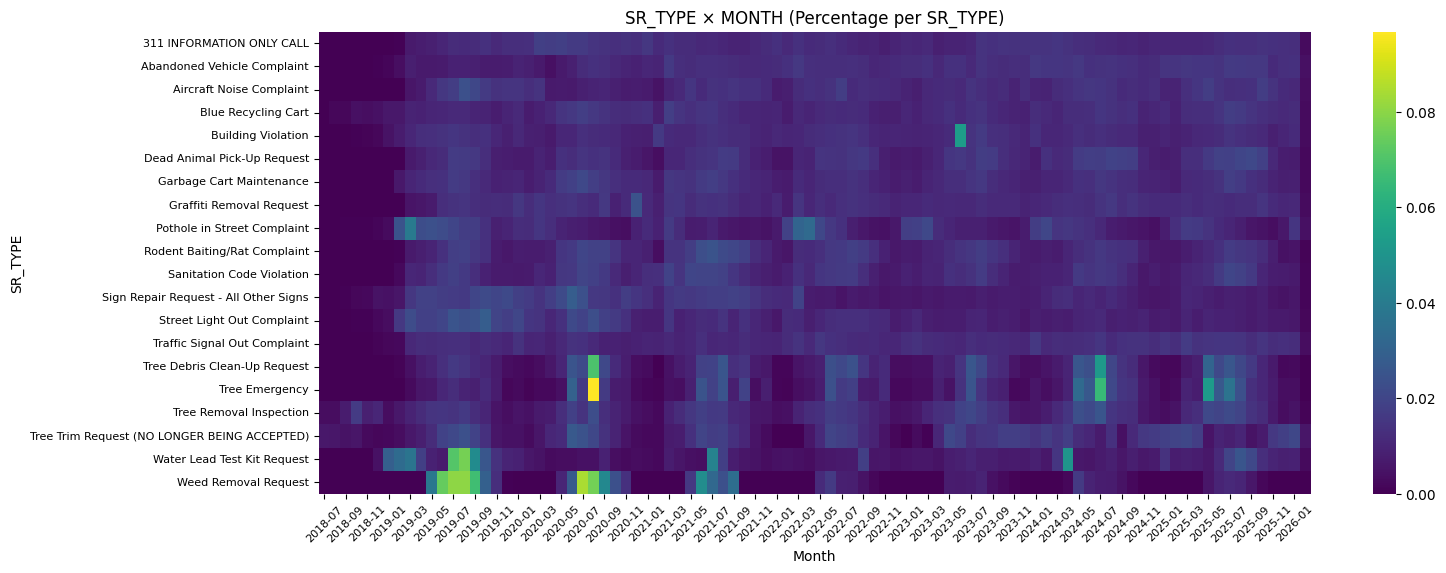

In [41]:
# SR_TYPE × MONTH — heatmap top 20
df = con.execute("""
WITH top_sr AS (
    SELECT SR_TYPE
    FROM data_6
    GROUP BY SR_TYPE
    ORDER BY COUNT(*) DESC
    LIMIT 20
)
SELECT
    d.SR_TYPE,
    STRFTIME(d.CREATED_DATE, '%Y-%m') AS month,
    COUNT(*) AS n
FROM data_6 d
JOIN top_sr t
  ON d.SR_TYPE = t.SR_TYPE
GROUP BY 1, 2
""").df()

# normalize per SR_TYPE (row sums to 1)
piv = (
    df
    .pivot(index="SR_TYPE", columns="month", values="n")
    .fillna(0)
)
piv = piv.div(piv.sum(axis=1), axis=0)

plt.figure(figsize=(16, max(6, 0.3 * len(piv))))
ax = sns.heatmap(piv, cmap="viridis", annot=False)
ax.set_xlabel("Month")
ax.set_ylabel("SR_TYPE")
ax.set_title("SR_TYPE × MONTH (Percentage per SR_TYPE)")
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
plt.show()

# Most SR types peak mid-year, consistent with the time-series results
# 'Pothole in the Street' shows an inverted seasonal pattern
# Several SR types exhibit no clear seasonality
#

## **Key Insights**


## **Limitations & Assumptions**


## **Next Steps**


### Feature engineering
- Temporal features: day of week, month, seasonality flags, holidays
- Spatial features: grid cell, hotspot indicator, distance to historical centroids
- Request features: SR_TYPE encoding, department, historical load per SR_TYPE
- Lagged features: recent volume, recent backlog by area and type

---

### Candidate models
- Ranking and prioritization: LambdaMART, LightGBM ranking
- Segmentation: K-Means, Gaussian Mixture Models
- Forecasting: ARIMA, SARIMA, Prophet, Gradient Boosting
- Risk / anomaly: Isolation Forest, One-Class SVM
- Inference

---

### Possible metrics
- Classification: ROC-AUC, PR-AUC, log loss
- Ranking: NDCG@k, MAP@k
- Forecasting: MAE, RMSE, MAPE
- Segmentation: Silhouette score, stability across samples
- Causal / uplift: Qini, AUUC

---

### ML pipeline integration
- Deterministic feature generation (DuckDB / SQL-first)
- Train–validation splits by time
- Experiment tracking and model registry
- Batch inference and periodic retraining
- Monitoring: data drift, performance decay, alerting